In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import mglearn
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import math

In [2]:
 df=pd.read_csv('lending_club_loan_two.csv')

In [3]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


In [4]:
len(df)

396030

<AxesSubplot:xlabel='loan_status', ylabel='count'>

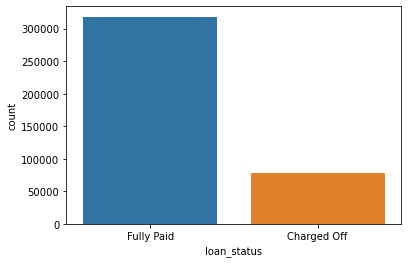

In [5]:
import seaborn as sns
sns.countplot(data=df,x='loan_status')

In [6]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

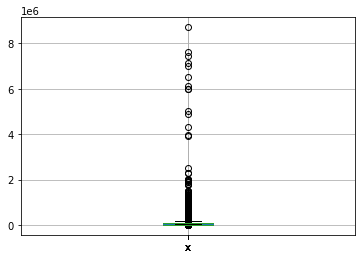

In [7]:
#Helper fucntions for outlier transformer
_, Fully_Paid = pd.DataFrame.boxplot(df['loan_amnt'], return_type='both')
Fully_Paid_uw = [whiskers.get_ydata() for whiskers in Fully_Paid["whiskers"]][1][1]
_,intrate=pd.DataFrame.boxplot(df['int_rate'],return_type='both')
intrate_uw=[whiskers.get_ydata() for whiskers in intrate["whiskers"]][1][1]
_,installment=pd.DataFrame.boxplot(df['installment'],return_type='both')
installment_uw=[whiskers.get_ydata() for whiskers in installment["whiskers"]][1][1]
_,annual_inc=pd.DataFrame.boxplot(df['annual_inc'],return_type='both')
annual_inc_uw=[whiskers.get_ydata() for whiskers in annual_inc["whiskers"]][1][1]
_,open_acc=pd.DataFrame.boxplot(df['open_acc'],return_type='both')
open_acc_uw=[whiskers.get_ydata() for whiskers in open_acc["whiskers"]][1][1]
_,pub_rec=pd.DataFrame.boxplot(df['pub_rec'],return_type='both')
pub_rec_uw=[whiskers.get_ydata() for whiskers in pub_rec["whiskers"]][1][1]
_,revol_bal=pd.DataFrame.boxplot(df['revol_bal'],return_type='both')
revol_bal_uw=[whiskers.get_ydata() for whiskers in revol_bal["whiskers"]][1][1]
_,total_acc=pd.DataFrame.boxplot(df['total_acc'],return_type='both')
total_acc_uw=[whiskers.get_ydata() for whiskers in total_acc["whiskers"]][1][1]


In [8]:
#Custom transformer to removing outliers
class outliers_transformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        X=X[X['loan_amnt'] <= Fully_Paid_uw]
        X=X[X['int_rate'] <= intrate_uw]
        X=X[X['installment'] <= installment_uw]
        X=X[X['annual_inc'] <= annual_inc_uw]
        X=X[X['open_acc'] <= open_acc_uw]
        X=X[X['pub_rec'] <= pub_rec_uw]
        X=X[X['revol_bal'] <= revol_bal_uw]
        X=X[X['total_acc'] <= total_acc_uw]
        return X

In [9]:
#Custom transformer for extracting coulmns from dataframe
class Feature_selector(BaseEstimator, TransformerMixin):
    #Constructor
    def __init__(self,feature_names):
        self._feature_names=feature_names
    
    #Fit method
    def fit(self,X,y=None):
        return self
    
    #Transform method
    def transform(self,X,y=None):
        return X[self._feature_names]

In [10]:
#Helper function for numerical_transformer
total_acc_avg = df.groupby('total_acc').mean()['mort_acc']

def fill_mort_acc(total_acc,mort_acc):
    '''
    Accepts the total_acc and mort_acc values for the row.
    Checks if the mort_acc is NaN , if so, it returns the avg mort_acc value
    for the corresponding total_acc value for that row.
    
    total_acc_avg here should be a Series or dictionary containing the mapping of the
    groupby averages of mort_acc per total_acc values.
    '''
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc


In [11]:
#Numerical transformer for handling numerical columns
class Numerical_transformer(BaseEstimator, TransformerMixin):
    def __init__(self,drop_feature_nm=['revol_util','pub_rec_bankruptcies']):
        self._drop_feature_nm=drop_feature_nm
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X=X.drop(self._drop_feature_nm,axis=1)
        X['mort_acc'] = X.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)
        return X
        

In [12]:
#Categorical transformer for handling categroical columns
class Categorical_transformer(BaseEstimator, TransformerMixin):
    def __init__(self,drop_feature_dm=['emp_title','emp_length','title','grade','issue_d','earliest_cr_line']):
        self._drop_feature_dm=drop_feature_dm
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        X=X.drop(self._drop_feature_dm,axis=1)
        X['term'] = X['term'].apply(lambda term: int(term[:3]))
        subgrade_dummies = pd.get_dummies(X['sub_grade'],drop_first=True)
        X = pd.concat([X.drop('sub_grade',axis=1),subgrade_dummies],axis=1)
        dummies1 = pd.get_dummies(X[['verification_status', 'application_type','initial_list_status','purpose']],drop_first=True)
        X = X.drop(['verification_status', 'application_type','initial_list_status','purpose'],axis=1)
        X = pd.concat([X,dummies1],axis=1)
        X['home_ownership']=X['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')
        dummies2 = pd.get_dummies(X['home_ownership'],drop_first=True)
        X = X.drop('home_ownership',axis=1)
        X = pd.concat([X,dummies2],axis=1)
        X['zip_code'] = X['address'].apply(lambda address:address[-5:])
        dummies3 = pd.get_dummies(X['zip_code'],drop_first=True)
        X = X.drop(['zip_code','address'],axis=1)
        X = pd.concat([X,dummies3],axis=1)
        #X['earliest_cr_year'] = X['earliest_cr_line'].apply(lambda date:int(date[-4:]))
        #X=X.drop('earliest_cr_line',axis=1)
        return X
    

In [13]:
#Creating entire pipeline by combining individual pipelines pipelines together
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#list of categorical features
categorical_features=['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status','purpose',
    'title', 'earliest_cr_line', 'initial_list_status','issue_d',
       'application_type', 'address']

#list of numerical features
numerical_features=['loan_amnt','int_rate','installment','annual_inc','dti',
       'open_acc','pub_rec','revol_bal','total_acc',
       'mort_acc','revol_util','pub_rec_bankruptcies']

#list of categorical features to be dropped
#drop_feature_dm=['emp_title','emp_length','title']

#1. Creating categorical pipeline
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', Feature_selector(categorical_features) ),
                                           ( 'cat_transformer', Categorical_transformer() ) ] )


#2. Creating numerical pipeline
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', Feature_selector(numerical_features)),
                                         ('num_transformer', Numerical_transformer()),
                                         ('std_scaler', MinMaxScaler())])
                                        

#3. Combining numerical and categorical pipeline into one full big pipeline horizontally using FeatureUnion
full_pipeline = FeatureUnion( transformer_list = [('categorical_pipeline', categorical_pipeline ), 
                                                  ('numerical_pipeline', numerical_pipeline)])

#preprocessor = ColumnTransformer(transformers=[('cat', categorical_pipeline, categorical_features),
#                                               ('num', numerical_pipeline, numerical_features)])
# The FeatureUnion object takes in pipeline objects containing only transformers. 
#A machine learning model is an estimator   
#Make another Pipeline object , and pass full_pipeline object as the first step 
#and add a machine learning model as the final step
#clf = Pipeline(steps=[('preprocessor', preprocessor),
#                      ('classifier', LogisticRegression())])

In [14]:
df['loan_repaid'] = df['loan_status'].map({'Fully Paid':1,'Charged Off':0})

In [15]:
df.drop('loan_status',inplace=True,axis=1)

In [22]:
y=df['loan_repaid'][:]

In [17]:
X=outliers_transformer().fit_transform(df.drop('loan_repaid',axis=1))

In [18]:
X=pd.DataFrame(full_pipeline.fit_transform(df))

In [19]:
X.dropna(inplace=True)

In [20]:
y

1         1
2         1
3         1
4         0
5         1
         ..
396025    1
396026    1
396027    1
396028    1
396029    1
Name: loan_repaid, Length: 396029, dtype: int64

In [23]:
X_train, X_test, y_train, y_test = train_test_split( X, y , test_size = 0.2 , random_state = 42 )

In [24]:
X_train_2, X_validation, y_train_2, y_validation=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [31]:
from sklearn.decomposition import PCA


In [32]:
pca=PCA(0.95)

In [34]:
pca.fit(X_train)

PCA(n_components=0.95)

In [35]:
X_train=pca.transform(X_train)
X_test=pca.transform(X_test)

In [152]:
y

1       Fully Paid
2       Fully Paid
3       Fully Paid
4       Fully Paid
5       Fully Paid
          ...     
995     Fully Paid
996     Fully Paid
997     Fully Paid
998    Charged Off
999     Fully Paid
Name: loan_status, Length: 999, dtype: object

# Fitting Logistic Regression

In [104]:
model=LogisticRegression(C=10)

In [105]:
model.fit(X_train_2,y_train_2)

/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [68]:
y_pred=model.predict(X_validation)

In [69]:
y_pred

array([1, 1, 1, ..., 1, 0, 1])

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [71]:
print(confusion_matrix(y_validation,y_pred))
print(classification_report(y_validation,y_pred))

[[ 5633  6724]
 [  298 50710]]
              precision    recall  f1-score   support

           0       0.95      0.46      0.62     12357
           1       0.88      0.99      0.94     51008

    accuracy                           0.89     63365
   macro avg       0.92      0.73      0.78     63365
weighted avg       0.90      0.89      0.87     63365



In [72]:
print(accuracy_score(y_validation,y_pred)*100)

88.91817249270102


In [73]:
param_grid={'C':[0.1,1,10,100]}
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, scoring="precision")
grid.fit(X_validation, y_validation)
print("\nGrid-Search with Precision")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (Precision): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
roc_auc_score(y_validation, grid.decision_function(X_validation))))
print("Test set accuracy: {:.3f}".format(grid.score(X_validation, y_validation)))

/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html


Grid-Search with AUC
Best parameters: {'C': 10}
Best cross-validation score (AUC): 0.883
Test set AUC: 0.903
Test set accuracy: 0.883


/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [74]:
from sklearn.model_selection import cross_val_score
accuracy = cross_val_score(LogisticRegression(C=10), X_train,y_train,cv=10)

/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [75]:
accuracy.mean()*100

88.73791086417725

In [76]:
precision_score = cross_val_score(LogisticRegression(C=10), X_train,y_train,cv=10,scoring='precision')

/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [77]:
recall_score = cross_val_score(LogisticRegression(C=10), X_train,y_train,cv=10,scoring='recall')

/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

In [80]:
print(precision_score.mean()*100)
print(recall_score.mean()*100)

88.04558588375417
99.50300028239576


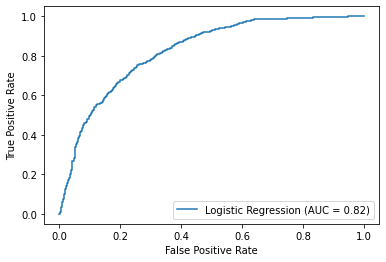

In [106]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model, X_test, y_test, name = 'Logistic Regression')

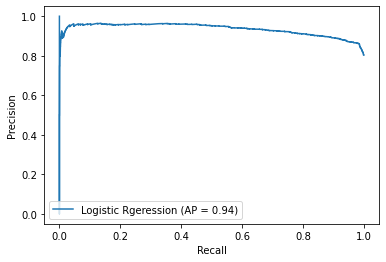

In [126]:
plot_precision_recall_curve(model, X_test, y_test, name = 'Logistic Rgeression')

# Fitting SVM

# Linear Kernel

In [107]:
from sklearn import svm

In [108]:
model_SVM=svm.LinearSVC(C=1)

In [109]:
model_SVM.fit(X_train_2,y_train_2)

/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(C=1)

In [85]:
y_pred_SVM=model_SVM.predict(X_validation)

In [86]:
(y_pred_SVM)

array([1, 1, 1, ..., 1, 0, 1])

In [87]:
print(confusion_matrix(y_validation,y_pred_SVM))
print(classification_report(y_validation,y_pred_SVM))

[[ 5398  6959]
 [    9 50999]]
              precision    recall  f1-score   support

           0       1.00      0.44      0.61     12357
           1       0.88      1.00      0.94     51008

    accuracy                           0.89     63365
   macro avg       0.94      0.72      0.77     63365
weighted avg       0.90      0.89      0.87     63365



In [88]:
print(accuracy_score(y_validation,y_pred_SVM)*100)

89.00339304032194


In [89]:
param_grid={'C':[0.1,1,10,100]}
grid = GridSearchCV(svm.LinearSVC(), param_grid=param_grid, scoring="precision")
grid.fit(X_validation, y_validation)
print("\nGrid-Search with precision")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (precision): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
roc_auc_score(y_validation, grid.decision_function(X_validation))))
print("Test set accuracy: {:.3f}".format(grid.score(X_validation, y_validation)))

/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: Converge


Grid-Search with precision
Best parameters: {'C': 1}
Best cross-validation score (precision): 0.888
Test set AUC: 0.903
Test set accuracy: 0.880


/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [92]:
scores1 = cross_val_score(svm.LinearSVC(C=1), X_train, y_train,cv=10)

/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: Converge

In [95]:
scores1.mean()*100

80.62416910769261

In [93]:
scores2=cross_val_score(svm.LinearSVC(C=1), X_train, y_train,cv=10,scoring='precision')

/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: Converge

In [94]:
scores3=cross_val_score(svm.LinearSVC(C=1), X_train, y_train,cv=10,scoring='recall')

/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/prabuddh/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: Converge

In [96]:
print(scores2.mean())
print(scores3.mean())

0.8902523533135908
0.8730248776379541


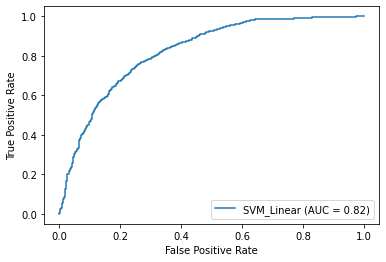

In [110]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(model_SVM, X_test, y_test, name = 'SVM_Linear')

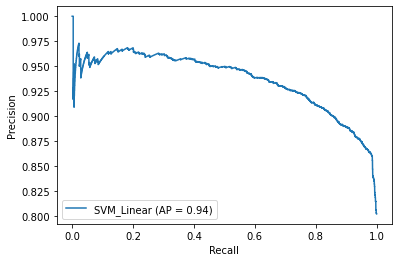

In [124]:
plot_precision_recall_curve(model_SVM, X_test, y_test, name = 'SVM_Linear')

# Polynomial Kernel

In [111]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=3,C=100)
svclassifier.fit(X_train_2, y_train_2)

SVC(C=100, kernel='poly')

In [42]:
y_pred_SVM_poly=svclassifier.predict(X_validation)

In [43]:
y_pred_SVM_poly

array([1, 1, 1, ..., 1, 1, 1])

In [44]:
print(confusion_matrix(y_validation,y_pred_SVM_poly))
print(classification_report(y_validation,y_pred_SVM_poly))

[[  62  370]
 [  13 1955]]
              precision    recall  f1-score   support

           0       0.83      0.14      0.24       432
           1       0.84      0.99      0.91      1968

    accuracy                           0.84      2400
   macro avg       0.83      0.57      0.58      2400
weighted avg       0.84      0.84      0.79      2400



In [45]:
print(accuracy_score(y_validation,y_pred_SVM_poly)*100)

84.04166666666667


In [46]:
param_grid={'C':[0.1,1,10,100],'degree':[3,4,5]}
grid = GridSearchCV(SVC(kernel='poly'), param_grid=param_grid, scoring="precision")
grid.fit(X_validation, y_validation)
print("\nGrid-Search with precision")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (precision): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
roc_auc_score(y_validation, grid.decision_function(X_validation))))
print("Test set accuracy: {:.3f}".format(grid.score(X_validation, y_validation)))


Grid-Search with precision
Best parameters: {'C': 100, 'degree': 3}
Best cross-validation score (precision): 0.850
Test set AUC: 0.863
Test set accuracy: 0.853


In [49]:
from sklearn.model_selection import cross_val_score
scores_poly_1 = cross_val_score(SVC(kernel='poly',C=100,degree=3), X_train, y_train,cv=10)

In [50]:
scores_poly_2 = cross_val_score(SVC(kernel='poly',C=100,degree=3), X_train, y_train,cv=10,scoring='precision')

In [51]:
scores_poly_3 = cross_val_score(SVC(kernel='poly',C=100,degree=3), X_train, y_train,cv=10,scoring='recall')

In [52]:
print(scores_poly_1.mean()*100)
print(scores_poly_2.mean()*100)
print(scores_poly_3.mean()*100)

85.69882541006395
86.19197945912455
98.03295571575696


In [57]:
final_SVM_poly=SVC(kernel='poly',degree=3,C=100)

In [58]:
final_SVM_poly.fit(X_train,y_train)

SVC(C=100, kernel='poly')

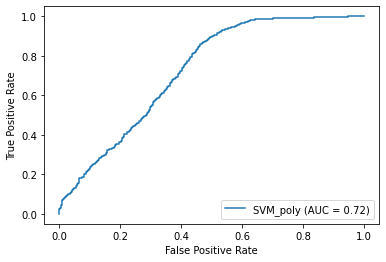

In [112]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(svclassifier, X_test, y_test, name = 'SVM_poly')

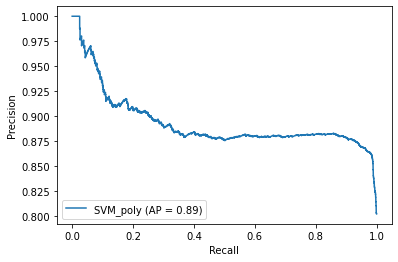

In [122]:
from sklearn.metrics import plot_precision_recall_curve
plot_precision_recall_curve(svclassifier, X_test, y_test, name = 'SVM_poly')

# Gaussian Kernel

In [113]:
from sklearn.svm import SVC
svclassifier1=SVC(kernel='rbf',C=10,gamma=0.1)
svclassifier1.fit(X_train_2, y_train_2)

SVC(C=10, gamma=0.1)

In [61]:
y_pred_SVM_rbf=svclassifier1.predict(X_validation)

In [62]:
print(confusion_matrix(y_validation,y_pred_SVM_rbf))
print(classification_report(y_validation,y_pred_SVM_rbf))

[[  17  415]
 [  27 1941]]
              precision    recall  f1-score   support

           0       0.39      0.04      0.07       432
           1       0.82      0.99      0.90      1968

    accuracy                           0.82      2400
   macro avg       0.61      0.51      0.48      2400
weighted avg       0.75      0.82      0.75      2400



In [63]:
print(accuracy_score(y_validation,y_pred_SVM_rbf)*100)

81.58333333333333


In [64]:
param_grid={'C':[0.1,1,10,100],'gamma':[0.1,5,100]}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, scoring="precision")
grid.fit(X_validation, y_validation)
print("\nGrid-Search with precision")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (precision): {:.3f}".format(grid.best_score_))
print("Test set AUC: {:.3f}".format(
roc_auc_score(y_validation, grid.decision_function(X_validation))))
print("Test set accuracy: {:.3f}".format(grid.score(X_validation, y_validation)))


Grid-Search with precision
Best parameters: {'C': 10, 'gamma': 0.1}
Best cross-validation score (precision): 0.878
Test set AUC: 0.974
Test set accuracy: 0.910


In [22]:
from sklearn.model_selection import cross_val_score
scores_gaussian_1 = cross_val_score(SVC(kernel='rbf',C=10,gamma=0.1), X_train, y_train,cv=10)

In [23]:
scores_gaussian_2 = cross_val_score(SVC(kernel='rbf',C=10,gamma=0.1), X_train, y_train,cv=10,scoring='precision')

In [24]:
scores_gaussian_3 = cross_val_score(SVC(kernel='rbf',C=10,gamma=0.1), X_train, y_train,cv=10,scoring='recall')

In [25]:
print(scores_gaussian_1.mean()*100)
print(scores_gaussian_2.mean()*100)
print(scores_gaussian_3.mean()*100)

86.12415572232646
86.65013000653875
97.86739314774387


In [26]:
final_SVM_rbf=SVC(kernel='rbf',C=10,gamma=0.1)
final_SVM_rbf.fit(X_train,y_train)

SVC(C=10, gamma=0.1)

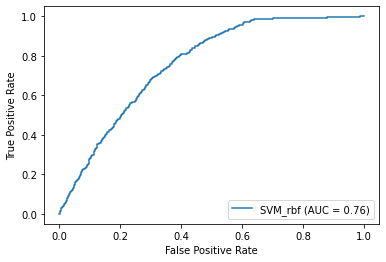

In [114]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(svclassifier1, X_test, y_test, name = 'SVM_rbf')

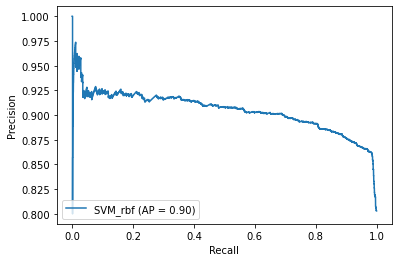

In [125]:
plot_precision_recall_curve(svclassifier1, X_test, y_test, name = 'SVM_rbf')

# ANN

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [26]:
model=Sequential()
model.add(Dense(78,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(39, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(19, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [34]:
model_ANN=Sequential()
model_ANN.add(Dense(90,  activation='relu'))
model_ANN.add(Dropout(0.2))

# hidden layer
model_ANN.add(Dense(68, activation='relu'))
model_ANN.add(Dropout(0.2))

# hidden layer
model_ANN.add(Dense(46, activation='relu'))
model_ANN.add(Dropout(0.2))

# hidden layer
model_ANN.add(Dense(24, activation='relu'))
model_ANN.add(Dropout(0.2))

# output layer
model_ANN.add(Dense(units=1,activation='sigmoid'))

# Compile model
model_ANN.compile(loss='binary_crossentropy', optimizer='adam')

In [27]:
model.fit(x=X_train_2, 
          y=y_train_2, 
          epochs=25,
          batch_size=256 
          )

Epoch 1/25

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

991/991 [==============================] - 2s 2ms/step - loss: 0.5453
Epoch 2/25
991/991 [==============================] - 2s 2ms/step - loss: 0.3051
Epoch 3/25
991/991 [==============================] - 3s 3ms/step - loss: 0.2766A: 0s - loss
Epoch 4/25
991/991 [==============================] - 3s 3ms/step - loss: 0.2704
Epoch 5/25
991/991 [==============================] - 4s 4ms/step - loss: 0.2676
Epoch 6/25
991/991 [==============================] - 3s 3ms/step - loss: 0.2659
Epoch 7/25

In [35]:
model_ANN.fit(x=X_train_2, 
          y=y_train_2, 
          epochs=25,
          batch_size=256,
          validation_data=(X_validation, y_validation)
          )

Epoch 1/25

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

991/991 [==============================] - 4s 4ms/step - loss: 0.4129 - val_loss: 0.2707
Epoch 2/25
991/991 [==============================] - 3s 3ms/step - loss: 0.2775 - val_loss: 0.2617
Epoch 3/25
991/991 [==============================] - 4s 4ms/step - loss: 0.2693 - val_loss: 0.2589
Epoch 4/25
991/991 [==============================] - 4s 4ms/step - loss: 0.2664 - val_loss: 0.2589
Epoch 5/25
991/991 [==============================] - 4s 4ms/step - loss: 0.2650 - val_loss: 0.2575
Epoch 6/

In [29]:
predictions = (model.predict(X_validation)>0.5).astype('int32')

In [31]:
print(confusion_matrix(y_validation,predictions))
print(classification_report(y_validation,predictions))

[[ 5423  6934]
 [   39 50969]]
              precision    recall  f1-score   support

           0       0.99      0.44      0.61     12357
           1       0.88      1.00      0.94     51008

    accuracy                           0.89     63365
   macro avg       0.94      0.72      0.77     63365
weighted avg       0.90      0.89      0.87     63365



In [33]:
print(accuracy_score(y_validation,predictions)*100)

88.99550224887555


In [21]:
def FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes):
    layers = []
    
    nodes_increment = (last_layer_nodes - first_layer_nodes)/ (n_layers-1)
    nodes = first_layer_nodes
    for i in range(1, n_layers+1):
        layers.append(math.ceil(nodes))
        nodes = nodes + nodes_increment
    
    return layers

In [36]:
FindLayerNodesLinear(5,90,1)

[90, 68, 46, 24, 1]

In [24]:
def createmodel(n_layers, first_layer_nodes, last_layer_nodes, activation_func, loss_func):
    model = Sequential()
    n_nodes = FindLayerNodesLinear(n_layers, first_layer_nodes, last_layer_nodes)
    for i in range(1, n_layers):
        if i==1:
            model.add(Dense(first_layer_nodes, input_dim=X_train.shape[1], activation=activation_func))
        else:
            model.add(Dense(n_nodes[i-1], activation=activation_func))
            
    #Finally, the output layer should have a single node in binary classification
    model.add(Dense(1, activation=activation_func))
    model.compile(optimizer='adam', loss=loss_func, metrics = ["accuracy"]) #note: metrics could also be 'mse'
    
    return model

##Wrap model into scikit-learn
model =  KerasClassifier(build_fn=createmodel, verbose = False)

In [67]:
ANN=createmodel(5,90,1,'sigmoid','binary_crossentropy')

In [50]:
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

In [32]:
activation_funcs = ['sigmoid'] 
loss_funcs = ['binary_crossentropy']
param_grid = dict(n_layers=[3,4,5], first_layer_nodes = [90], last_layer_nodes = [1],activation_func=activation_funcs,loss_func=loss_funcs ,batch_size = [256], epochs = [60])
grid = GridSearchCV(estimator = model, param_grid = param_grid,scoring='precision')
grid.fit(X_validation, y_validation)
print("\nGrid-Search with precision")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score (precision): {:.3f}".format(grid.best_score_))
print("Test set accuracy: {:.3f}".format(grid.score(X_validation, y_validation)))


Grid-Search with precision
Best parameters: {'activation_func': 'sigmoid', 'batch_size': 256, 'epochs': 60, 'first_layer_nodes': 90, 'last_layer_nodes': 1, 'loss_func': 'binary_crossentropy', 'n_layers': 5}
Best cross-validation score (precision): 0.870
Test set accuracy: 0.868


# Plotting ROC curves

In [79]:
losses = pd.DataFrame(model_ANN.history.history)

In [ ]:
#Calculating TP,TN,FP,FN
def calc_TP_FP_rate(y_true, y_pred):
    
    # Convert predictions to series with index matching y_true
    y_pred = pd.Series(y_pred, index=y_true.index)
    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in y_true.index: 
        if y_true[i]==y_pred[i]==1:
           TP += 1
        if y_pred[i]==1 and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0:
           TN += 1
        if y_pred[i]==0 and y_test[i]!=y_pred[i]:
           FN += 1
    
    # Calculate true positive rate and false positive rate
    tpr = TP / (TP + FN)
    fpr = FP / (FP + TN)

    return tpr, fpr


#For all threshold probabilities
lr = LogisticRegression(max_iter=1000, penalty='none')
lr.fit(X_train, y_train)
y_test_probs = lr.predict_proba(X_test)[:,1]

# Containers for true positive / false positive rates
lr_tp_rates = []
lr_fp_rates = []

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0,1,num=100)

# Find true positive / false positive rate for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    tp_rate, fp_rate = calc_TP_FP_rate(y_test, y_test_preds)
        
    lr_tp_rates.append(tp_rate)
    lr_fp_rates.append(fp_rate)
    
    
#Plotting the curve
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(lr_fp_rates, lr_tp_rates, label='Logistic Regression')
ax.plot(l2_fp_rates, l2_tp_rates, label='L2 Logistic Regression')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend();

In [36]:
predictions1 = (model_ANN.predict(X_test)>0.5).astype('int32')

In [37]:
print(confusion_matrix(y_test,predictions1))
print(classification_report(y_test,predictions1))

[[ 6694  8883]
 [    7 63622]]
              precision    recall  f1-score   support

           0       1.00      0.43      0.60     15577
           1       0.88      1.00      0.93     63629

    accuracy                           0.89     79206
   macro avg       0.94      0.71      0.77     79206
weighted avg       0.90      0.89      0.87     79206



In [38]:
print(accuracy_score(y_test,predictions1)*100)

88.77610282049339
